# How to use the COSIMA Cookbook

This notebook is designed to help new users get to grips with the COSIMA Cookbook.

It assumes that:
 * You have access to the COSIMA cookbook.
 * We recommend using the latest version of the cookbook available through the `conda/analysis3-unstable` module on NCI.
 * You can fire up a Jupyter notebook!

**Before starting,** load in some standard libraries that you are likely to need:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import cmocean as cm
import xarray as xr
import numpy as np
import IPython.display

In addition, you **always** need to load the `cosima_cookbook` module. This provides a bunch of functions that we use:

In [2]:
import cosima_cookbook as cc

## 1. The Cookbook Philosophy
The COSIMA Cookbook is a framework for analysing ocean-sea ice model output.
It is designed to:

* Provide examples of commonly used diagnostics;
* Write efficient, well-documented, openly accessible code;
* Encourage community input to the code;
* Ensure diagnostic results are reproducible;
* Process diagnostics directly from the model output, minimising creation of intermediate files;
* Find methods to deal with the memory limitations of analysing high-resolution model output.


### 1.1 A database of experiments
The COSIMA Cookbook relies on a database of experiments in order to load model output. This database effectively holds metadata for each experiment, as well as variable names, data ranges and so on. 

**NCI Projects**: Before accessing data users should make sure they are members of projects: `hh5`, `ik11`, `cj50`, and `jk72`.

With that sorted out, there are three different ways for you to access the database:

1. Use the default database, which is periodically refreshed automatically. This database sits in `/g/data/ik11/databases/cosima_master.db` and should be readable for all users. It includes all experiments stored in the COSIMA data directories on NCI under variou projects mentioned above. The examples in this tutorial use this database.

2. Use some of the databases sitting in `/g/data/ik11/databases/`. Note that some may *not* be up to date.

3. Make your own database, which is stored in your own path and includes only the experiments you are interested in. Please refer to the `Make_Your_Own_Database` tutorial for instructions on how to create this database.

To access the default database, you need to start a database session each time you fire up a notebook:

In [3]:
session = cc.database.create_session()

### 1.2 Inbuilt Database Functions

We have constructed a few functions to help you operate the cookbook and to access the datasets. These functions all sit in the `cosima_cookbook` directory. The following functions query the data available in the database, without loading the data itself.

They return `pandas` dataframes, which by default are truncated to show only the first and last 5 rows. To see more results, we need to set an option in `pandas` itself:

```python
import pandas as pd
pd.set_option("display.max_rows", n)
```

Where `n` is the maximum number of rows to display without truncation; if there are more rows, the result will again be truncated. Pass `None` to never truncate (but some dataframes can be very big!)

`get_experiments` lists all of the experiments that are catalogued in the database.

In [4]:
cc.querying.get_experiments(session)

,experiment,ncfiles
0,woa18,24
1,eac-zstar-v1,29
2,eac-zstar-v2,76
3,025deg_jra55_ryf9091_gadi_norediGM,312
4,025deg_jra55_ryf9091_gadi_noGM,316
...,...,...
159,01deg_jra55v140_iaf_cycle4_jra55v150_extension,8485
160,025deg_jra55_ryf9091_GMhi,27588
161,01deg_jra55v150_iaf_cycle1,6000
162,basal_melt_outputs,2372


Internally, an experiment is a set of netCDF4 files as shown in the above table.

`get_ncfiles` provides a list of all the netcdf filenames saved for a given experiment along with the time stamp for when that file was added to the cookbook database. Note that each of these filenames are present in some or all of the output directories -- **but the cookbook philosophy is that you don't need to know about the directories in which these files are stored**. To see the relevant files:

In [5]:
cc.querying.get_ncfiles(session, '025deg_jra55v13_iaf_gmredi6')

,ncfile,index_time
0,output000/ice/OUTPUT/iceh.1958-01.nc,2022-06-17 10:35:19.884907
1,output000/ice/OUTPUT/iceh.1958-02.nc,2022-06-15 20:27:00.950424
2,output000/ice/OUTPUT/iceh.1958-03.nc,2022-05-20 18:19:02.443077
3,output000/ice/OUTPUT/iceh.1958-04.nc,2022-05-20 18:09:59.346391
4,output000/ice/OUTPUT/iceh.1958-05.nc,2022-05-20 17:58:46.536143
...,...,...
4721,restart150/ice/mice.nc,2022-05-31 19:53:09.657403
4722,restart150/ice/monthly_sstsss.nc,2022-05-20 18:19:57.159255
4723,restart150/ice/o2i.nc,2022-06-15 20:17:46.383853
4724,restart150/ice/sicemass.nc,2022-06-17 10:45:46.842706


More usefully, `get_variables` provides a list of all the variables available in a specific experiment. 

In [6]:
cc.querying.get_variables(session, experiment='025deg_jra55v13_iaf_gmredi6', frequency='1 monthly')

,name,long_name,units,frequency,ncfile,cell_methods,# ncfiles,time_start,time_end
0,ANGLE,angle grid makes with latitude line on U grid,radians,1 monthly,output153/ice/OUTPUT/iceh.2257-12.nc,None,3599,1958-01-01 00:00:00,2258-01-01 00:00:00
1,ANGLET,angle grid makes with latitude line on T grid,radians,1 monthly,output153/ice/OUTPUT/iceh.2257-12.nc,None,3599,1958-01-01 00:00:00,2258-01-01 00:00:00
2,HTE,T cell width on East side,m,1 monthly,output153/ice/OUTPUT/iceh.2257-12.nc,None,3599,1958-01-01 00:00:00,2258-01-01 00:00:00
3,HTN,T cell width on North side,m,1 monthly,output153/ice/OUTPUT/iceh.2257-12.nc,None,3599,1958-01-01 00:00:00,2258-01-01 00:00:00
4,NCAT,category maximum thickness,m,1 monthly,output153/ice/OUTPUT/iceh.2257-12.nc,None,3599,1958-01-01 00:00:00,2258-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...
187,vvel_m,ice velocity (y),m/s,1 monthly,output153/ice/OUTPUT/iceh.2257-12.nc,time: mean,3599,1958-01-01 00:00:00,2258-01-01 00:00:00
188,xt_ocean,tcell longitude,degrees_E,1 monthly,output153/ocean/ocean_snapshot.nc,None,308,1957-12-30 00:00:00,2257-12-30 00:00:00
189,xu_ocean,ucell longitude,degrees_E,1 monthly,output153/ocean/ocean_snapshot.nc,None,308,1957-12-30 00:00:00,2257-12-30 00:00:00
190,yt_ocean,tcell latitude,degrees_N,1 monthly,output153/ocean/ocean_snapshot.nc,None,308,1957-12-30 00:00:00,2257-12-30 00:00:00


Since this is a pretty big list, we can search the dataframe for variable names which contain a specific string.

In [7]:
vars_025deg = cc.querying.get_variables(session, experiment='025deg_jra55v13_iaf_gmredi6')
vars_025deg[vars_025deg['name'].str.lower().str.contains('temp')]

,name,long_name,units,frequency,ncfile,cell_methods,# ncfiles,time_start,time_end
1,TEMP,None,None,None,restart080/ice/monthly_sstsss.nc,None,17,None,None
107,surface_temp,Conservative temperature,deg_C,1 daily,output153/ocean/ocean_daily.nc,time: mean,34,2197-12-30 00:00:00,2257-12-30 00:00:00
185,neutral_diffusion_temp,rho*dzt*cp*explicit neutral diffusion tendency...,Watts/m^2,1 monthly,output153/ocean/ocean_month.nc,time: mean,34,2197-12-30 00:00:00,2257-12-30 00:00:00
186,neutral_gm_temp,rho*dzt*cp*GM stirring (heating),Watts/m^2,1 monthly,output153/ocean/ocean_month.nc,time: mean,34,2197-12-30 00:00:00,2257-12-30 00:00:00
191,pot_temp,Potential temperature,degrees K,1 monthly,output153/ocean/ocean_month.nc,time: mean,34,2197-12-30 00:00:00,2257-12-30 00:00:00
228,surface_temp,Conservative temperature,deg_C,1 monthly,output153/ocean/ocean_month.nc,time: mean,154,1957-12-30 00:00:00,2257-12-30 00:00:00
234,temp,Conservative temperature,deg_C,1 monthly,output153/ocean/ocean_month.nc,time: mean,34,2197-12-30 00:00:00,2257-12-30 00:00:00
235,temp_advection,cp*rho*dzt*advection tendency,Watts/m^2,1 monthly,output153/ocean/ocean_month.nc,time: mean,34,2197-12-30 00:00:00,2257-12-30 00:00:00
236,temp_eta_smooth,surface smoother for temp,Watts/m^2,1 monthly,output153/ocean/ocean_month.nc,time: mean,34,2197-12-30 00:00:00,2257-12-30 00:00:00
237,temp_global_ave,Global mean temp in liquid seawater,deg_C,1 monthly,output153/ocean/ocean_scalar.nc,time: mean,154,1957-12-30 00:00:00,2257-12-30 00:00:00


Omitting the `frequency` would give variables at all temporal frequencies.  To determine what frequencies are in a given experient, we can use `get_frequencies`. Leaving off the `experiment` gives all possible frequencies.

In [8]:
cc.querying.get_frequencies(session, experiment='025deg_jra55v13_iaf_gmredi6')

,frequency
0,None
1,1 daily
2,1 monthly
3,1 yearly
4,static


### 1.3 Loading data from a netcdf file

Python has many ways of reading in data from a netcdf file ... so we thought we would add another way. This is done via the `querying.getvar()` function, which is the most commonly used function in the cookbook. This function queries the database to find a specific variable, and loads some or all of that file.

Let's take now a little while to get to know this function. In it's simplest form, you need just three arguments: `experiment`, `variable`, and database's `session`. 

You can see all the available options using the inbuilt help function, which brings up the function's documentation.

In [9]:
help(cc.querying.getvar)

Help on function getvar in module cosima_cookbook.querying:

getvar(expt, variable, session, ncfile=None, start_time=None, end_time=None, n=None, frequency=None, attrs=None, attrs_unique=None, return_dataset=False, **kwargs)
    For a given experiment, return an xarray DataArray containing the
    specified variable.
    
    expt - text string indicating the name of the experiment
    variable - text string indicating the name of the variable to load
    session - a database session created by cc.database.create_session()
    ncfile -  an optional text string indicating the pattern for filenames
              to load. All filenames containing this string will match, so
              be specific. '/' can be used to match the start of the
              filename, and '%' is a wildcard character.
    start_time - only load data after this date. specify as a text string,
                 e.g. '1900-01-01'
    end_time - only load data before this date. specify as a text string,
           

You may like to note a few things about this function:
1. The data is returned as an xarray DataArray, which includes the coordinate and attribute information from the netcdf file (more on xarray later). 
2. The variable time does not start at zero - and if you don't like it you can introduce an offset to alter the time axis.
3. By default, we load the whole dataset, but we can load a subset of the times (see below).
4. Other customisable options include setting the variable chunking and incorporating a function to operate on the data.

In [10]:
experiment = '025deg_jra55v13_iaf_gmredi6'
variable = 'temp_global_ave'

darray = cc.querying.getvar(experiment, variable, session)
darray

<xarray.DataArray 'temp_global_ave' (time: 3600, scalar_axis: 1)>
dask.array<concatenate, shape=(3600, 1), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * scalar_axis  (scalar_axis) float64 0.0
  * time         (time) datetime64[ns] 1958-01-14T12:00:00 ... 2257-12-14T12:...
Attributes:
    long_name:      Global mean temp in liquid seawater
    units:          deg_C
    valid_range:    [ -10. 1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_i...

You can see that this operation loads the globally averaged potential temperature  from the model output. The time axis runs from 1900 to 2198. For some variables (particularly 3D variables that might use a lot of memory) you may prefer to restrict yourself to a smaller time window:

In [11]:
darray = cc.querying.getvar(experiment, variable, session,
                            start_time = '2000-01-01',
                            end_time = '2050-12-31')
darray

<xarray.DataArray 'temp_global_ave' (time: 624, scalar_axis: 1)>
dask.array<concatenate, shape=(624, 1), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * scalar_axis  (scalar_axis) float64 0.0
  * time         (time) datetime64[ns] 2000-01-14T12:00:00 ... 2051-12-14T12:...
Attributes:
    long_name:      Global mean temp in liquid seawater
    units:          deg_C
    valid_range:    [ -10. 1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_i...

You will see that the time boundaries are not exact here. `cc.querying.getvar` loads all files that include any dates within the specified range.  You can use `.sel(time = ...)` to refine this selection if required (see below).

### 1.4 Exercises
OK, this is a tutorial, so now you have to do some work. Your tasks are to:
* Find and load SSH from an experiment (an experiment... perhaps choose a 1° configuration for start).

* Just load the last 10 files from an experiment (any variable you like).

* Load potential temperature from an experiment (again, 1° would be quickest). Can you chunk the data differently from the default?

## 2. How to manipulate and plot variables with xarray
We use the python package `xarray` (which is built on `dask`, `pandas`, `matplotlib` and `numpy`) for many of our diagnostics. `xarray` has a a lot of nice features, some of which we will try to demonstrate for you. 

### 2.1 Plotting
`xarray`'s `.plot()` method does its best to figure out what you are trying to plot, and plotting it for you. Let's start by loading a 1-dimensional variable and plotting.

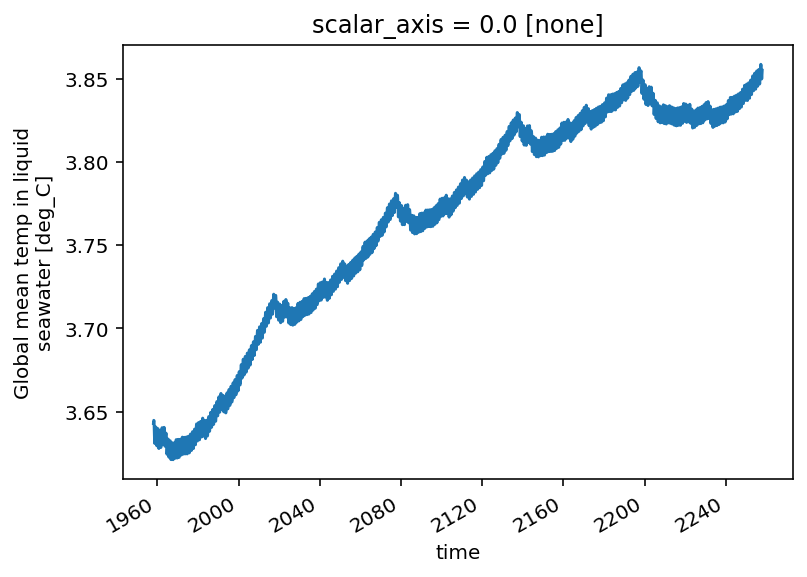

In [12]:
experiment = '025deg_jra55v13_iaf_gmredi6'
variable = 'temp_global_ave'
darray = cc.querying.getvar(experiment, variable, session)
darray.plot();

In [13]:
darray

<xarray.DataArray 'temp_global_ave' (time: 3600, scalar_axis: 1)>
dask.array<concatenate, shape=(3600, 1), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * scalar_axis  (scalar_axis) float64 0.0
  * time         (time) datetime64[ns] 1958-01-14T12:00:00 ... 2257-12-14T12:...
Attributes:
    long_name:      Global mean temp in liquid seawater
    units:          deg_C
    valid_range:    [ -10. 1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_i...

You should see that `xarray` has figured out that this data is a timeseries, that the x-axis is representing time and that the y-axis is `temp_global_ave`. You can always modify aspects of your plot if you are unhappy with the default xarray behaviour:

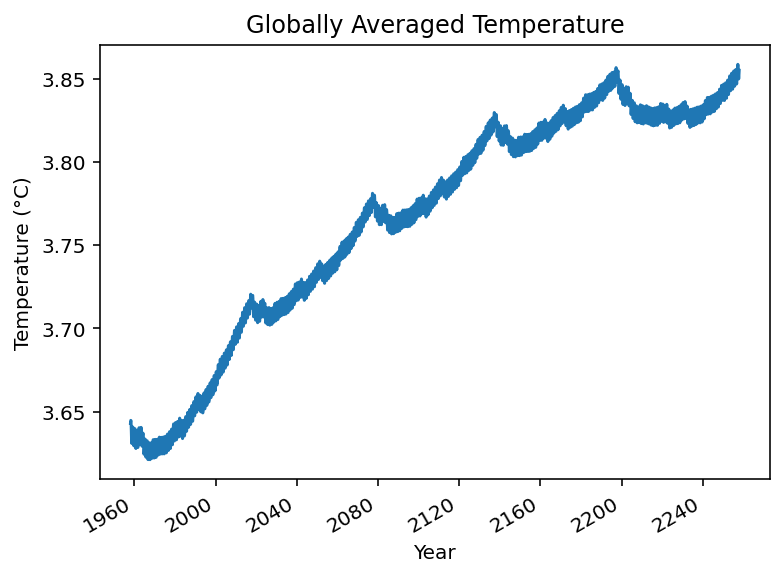

In [14]:
darray.plot()
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Globally Averaged Temperature');

Because `xarray` knows about dimensions, it has plotting routines which can figure out what it should plot. By way of example, let's load a single time slice of `surface_temp` and see how `.plot()` handles it: 

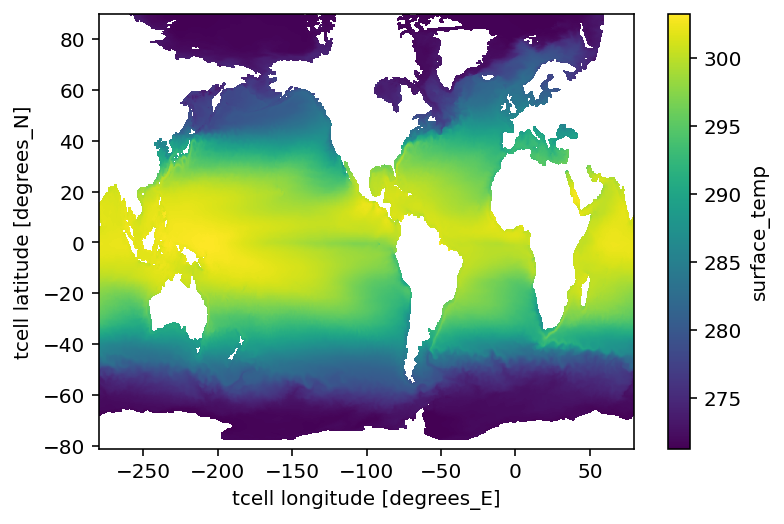

In [15]:
experiment = '025deg_jra55v13_iaf_gmredi6'
variable = 'surface_temp'
darray = cc.querying.getvar(experiment, variable, session, n=-1)
darray.mean('time').plot();

Again, you can customise this plot as you see fit:

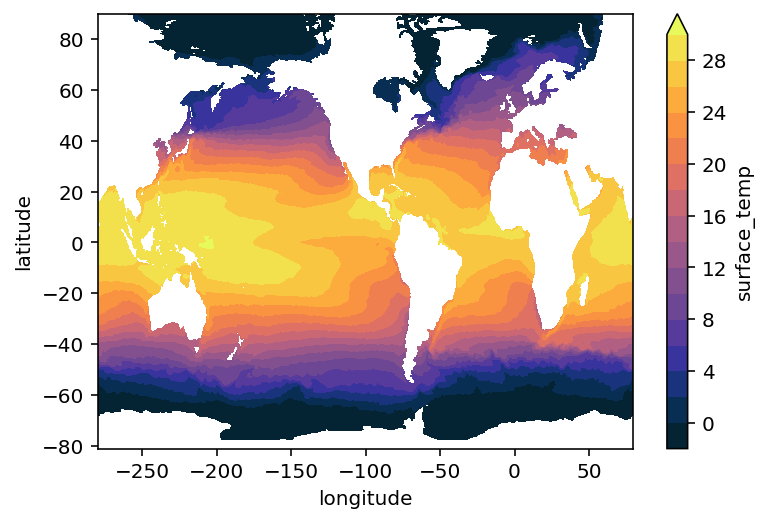

In [16]:
temp_C = darray - 273.15 # convert from Kelvin to Celsius
temp_C.mean('time').plot.contourf(levels=np.arange(-2, 32, 2), cmap=cm.cm.thermal);
plt.ylabel('latitude')
plt.xlabel('longitude');

### 2.2 Slicing and dicing

There are two different ways of subselecting from a DataArray: `isel` and `sel`. The first of these is probably what you are used to -- you specify the value of the index of the array. In the second case you specify the value of the coordinate you want to select. These two methods are demonstrated in the following example:

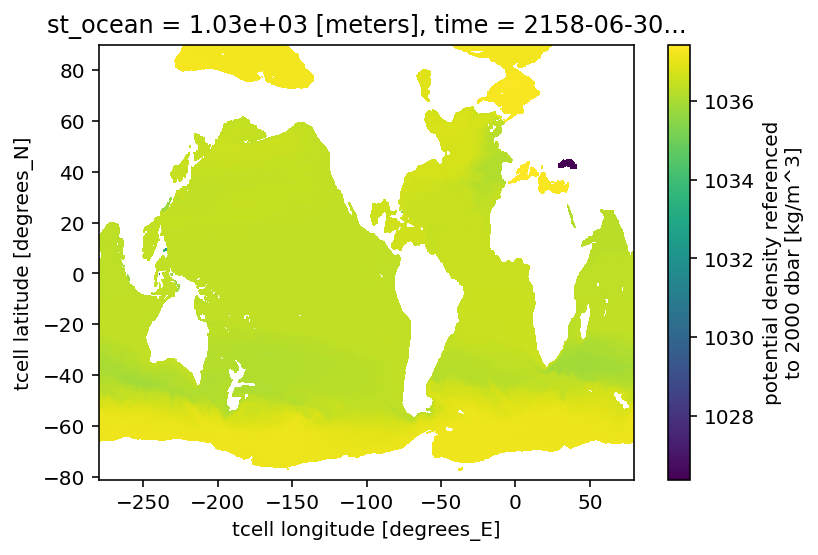

In [17]:
darray = cc.querying.getvar('025deg_jra55v13_iaf_gmredi6', 'pot_rho_2', session)
density = darray.isel(time = 200).sel(st_ocean = 1000, method='nearest')
density.plot();

In the above example, a 300-year dataset is loaded. We then use `isel` to select the 201st year (time index of 200) and use `sel` to select the $z$ level that is cabout 1000m deep. The `sel` method is very flexible, allowing us to use similar code in differing model resolutions or grids. In addition, both methods allow you to slice a range of values:

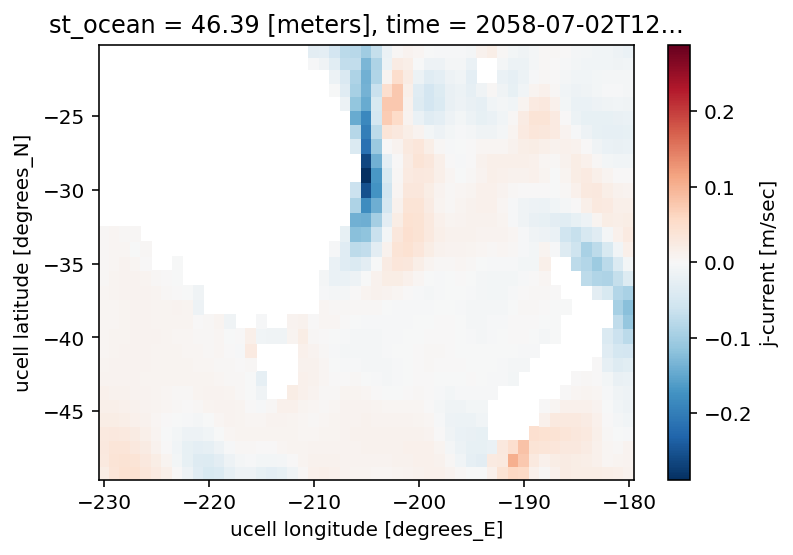

In [18]:
darray = cc.querying.getvar('1deg_jra55v13_iaf_spinup1_B1', 'v', session, ncfile="ocean.nc")
v = darray.isel(time = 100).sel(st_ocean=50, method='nearest').sel({'xu_ocean': slice(-230, -180),
                                                                    'yu_ocean': slice(-50, -20)})
v.plot();

Here we have taken meridional velocity, and sliced out a small region of interest for our plot.

### 2.3 Averaging along dimensions

We often perform operations such as averaging on dataarrays. Again, knowledge of the coordinates can be a big help here, as you can instruct the `mean()` method to operate along given coordinates. The case below takes a temporal and zonal average of potential density.

#### IMPORTANT
To be precise, it is actually a mean in the $i$-grid direction, which is only zonal outside the tripolar region in the Arctic, i.e., *south of 65N* in the ACCESS-OM2 models. To compute the zonal mean correctly one needs to be a bit more carefull; see the [`DocumentedExamples/True_Zonal_Mean.ipynb`](https://cosima-recipes.readthedocs.io/en/latest/documented_examples/True_Zonal_Mean.html#gallery-documented-examples-true-zonal-mean-ipynb).

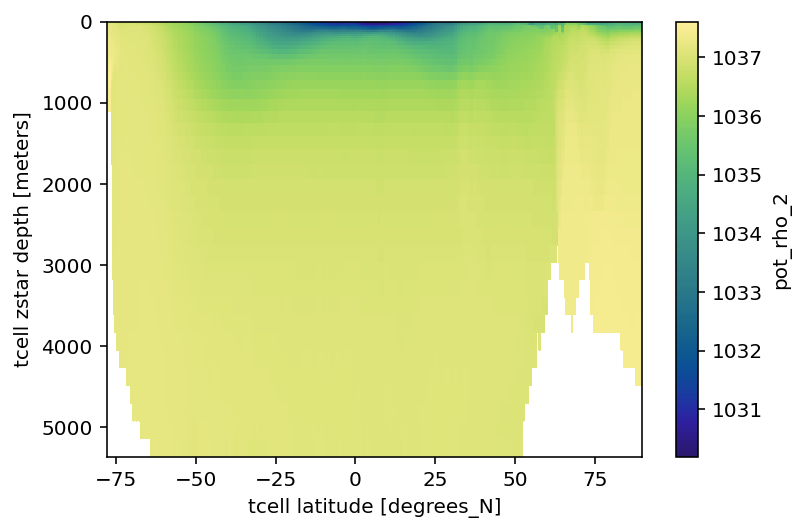

In [19]:
darray = cc.querying.getvar('1deg_jra55v13_iaf_spinup1_B1', 'pot_rho_2', session, n=-10)
darray.mean({'time', 'xt_ocean'}).plot(cmap=cm.cm.haline)
plt.gca().invert_yaxis();

### 2.4 Resampling

`xarray` uses `datetime` conventions to allow for operations such as resampling in time. This resampling is simple and powerful. Here is an example of re-plotting the figure from 2.1 with annual averaging:

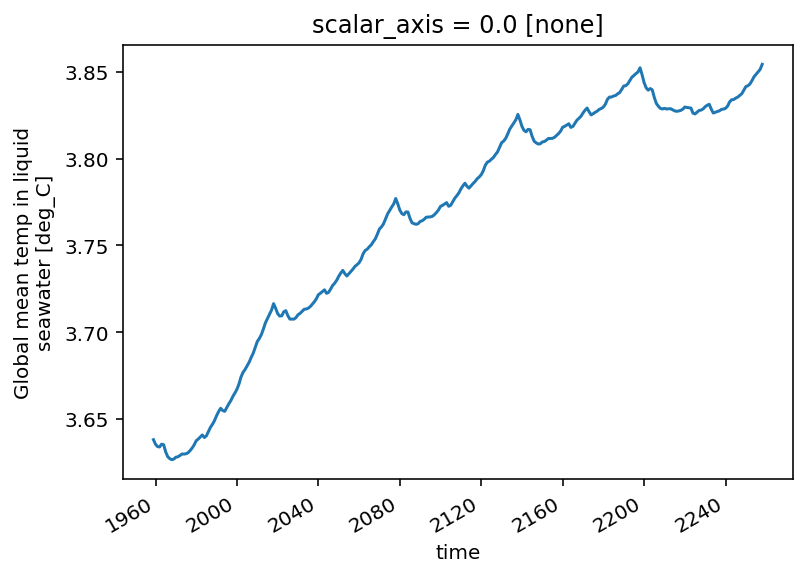

In [20]:
darray = cc.querying.getvar('025deg_jra55v13_iaf_gmredi6', 'temp_global_ave', session)
meandata = darray.resample(time='A').mean(dim='time')
meandata.plot();

### 2.5 Exercises

 * Pick an experiment and plot a map of the temperature of the upper 100m of the ocean for one year.

 * Now, take the same experiment and construct a timeseries of spatially averaged (regional or global) upper 700m temperature, resampled every 3 years.

## 3. More Advanced Stuff

### 3.1 Making a map with cartopy
Refer to [map tutorial](https://cosima-recipes.readthedocs.io/en/latest/tutorials/Making_Maps_with_Cartopy.html#gallery-tutorials-making-maps-with-cartopy-ipynb).

### 3.2 Distributed computing

Many of our scripts use multiple cores for their calculations, usually via the following . It sets up a local cluster on your node for distributed computation. 

In [21]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42889,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:44119,Total threads: 3
Dashboard: /proxy/44067/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:32781,


The dashboard link should allow you to access information on how your work is distributed between the cores on your local cluster.